<a href="https://www.kaggle.com/code/dsptlp/classificationtosql?scriptVersionId=163632354" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Classification
- Build Classification Model
- Extract features and build SQL Code Implementation

## Key Features:
### Data Loading and Preprocessing:

- The script loads a heart-related dataset from a CSV file, handles missing values, and encodes categorical variables.
- Robust scaling is applied to continuous features.

### Model Training and Evaluation:

- Several classification models (e.g., AdaBoost, Logistic Regression, Random Forest, Gradient Boosting) are trained and evaluated.
- Model evaluation includes accuracy, confusion matrix, and ROC AUC. Cross-validation is implemented for more robust performance assessment.

### Hyperparameter Tuning:

- Hyperparameter tuning is performed for RandomForestClassifier and LogisticRegression using GridSearchCV.

### Feature Importance (Tree-based Models):

- For tree-based models, feature importance is extracted and displayed.

### Model Saving:

- Trained models are saved using joblib for potential deployment.


In [1]:
try:
    import imblearn
except ImportError:
    print("imbalanced-learn not found. Installing...")
    !pip install imbalanced-learn
    print("imbalanced-learn installed successfully!")

# Now import and use imbalanced-learn
from imblearn.over_sampling import RandomOverSampler

In [2]:
# Importing necessary packages
import os
import numpy as np
import pandas as pd
import logging
import warnings
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.metrics import classification_report, roc_curve, accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, precision_recall_curve
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
import matplotlib.pyplot as plt

# Setting up options and ignoring warnings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('float_format', '{:f}'.format)
warnings.filterwarnings('ignore')

# Setting up logging with a FileHandler
log_file_path = 'classification_log.txt'
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')

file_handler = logging.FileHandler(log_file_path)
file_handler.setLevel(logging.INFO)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))

logger = logging.getLogger(__name__)
logger.addHandler(file_handler)

In [3]:
# Reading the dataset
dataset_path = "../input/heart-attack-analysis-prediction-dataset/heart.csv"

try:
    # Attempt to read the dataset
    df = pd.read_csv(dataset_path)
    logger.info(f"Dataset loaded successfully from {dataset_path}")
except FileNotFoundError:
    logger.error("Error: Dataset file not found. Please provide the correct file path.")
except Exception as e:
    logger.error(f"An error occurred: {e}")

In [4]:
# creating a copy of df
df1 = df.fillna(0)

# define the columns to be encoded and scaled
cat_cols = ['sex','exng','caa','cp','fbs','restecg','slp','thall']
con_cols = ["age","trtbps","chol","thalachh","oldpeak"]

# encoding the categorical columns
df1 = pd.get_dummies(df1, columns = cat_cols, drop_first = True)

# defining the features and target
X = df1.drop(['output'],axis=1)
y = df1[['output']]

# instantiating the scaler
scaler = RobustScaler()

# scaling the continuous featuree
X[con_cols] = scaler.fit_transform(X[con_cols])

# Get centering and scaling values for each feature
centering = scaler.center_
iqrs  = scaler.scale_

X.head()

,age,trtbps,chol,thalachh,oldpeak,sex_1,exng_1,caa_1,caa_2,caa_3,caa_4,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,slp_1,slp_2,thall_1,thall_2,thall_3
0,0.592593,0.750000,-0.110236,-0.092308,0.937500,1,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0
1,-1.333333,0.000000,0.157480,1.046154,1.687500,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,-1.037037,0.000000,-0.566929,0.584615,0.375000,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,0.074074,-0.500000,-0.062992,0.769231,0.000000,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0
4,0.148148,-0.500000,1.795276,0.307692,-0.125000,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0


In [5]:
# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [6]:
# Defining a dictionary of classification models
classifiers = {
    'AdaBoostClassifier': AdaBoostClassifier(),
    'LogisticRegression': LogisticRegression(random_state=9),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=100, random_state=0),
    'GradientBoostingClassifier': GradientBoostingClassifier(n_estimators=300, max_depth=1, subsample=0.8, max_features=0.2),
    'XGBClassifier': xgb.XGBClassifier(eval_metric='error'),
}

In [7]:
# Handling Class Imbalance with RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

AdaBoostClassifier CV Scores: [0.83333333 0.83018868 0.75471698 0.81132075 0.83018868]
AdaBoostClassifier Accuracy: 0.7868852459016393
AdaBoostClassifier Confusion Matrix: [[25  4]
 [ 9 23]]
AdaBoostClassifier ROC AUC: 0.8383620689655171
              precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.85      0.72      0.78        32

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.80      0.79      0.79        61



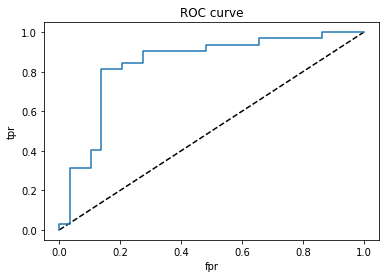

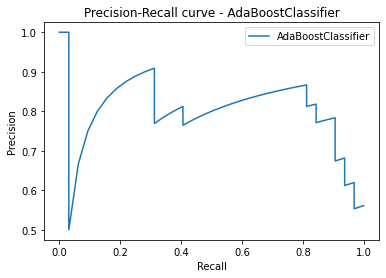

LogisticRegression CV Scores: [0.87037037 0.83018868 0.77358491 0.88679245 0.77358491]
LogisticRegression Accuracy: 0.9016393442622951
LogisticRegression Confusion Matrix: [[27  2]
 [ 4 28]]
LogisticRegression ROC AUC: 0.9375
              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



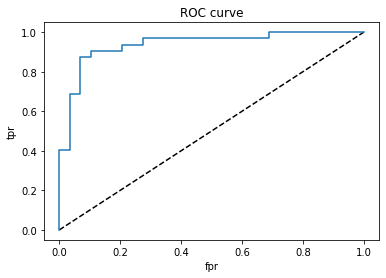

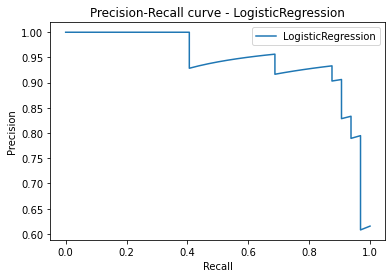

KNeighborsClassifier CV Scores: [0.7962963  0.81132075 0.75471698 0.88679245 0.83018868]
KNeighborsClassifier Accuracy: 0.8688524590163934
KNeighborsClassifier Confusion Matrix: [[25  4]
 [ 4 28]]
KNeighborsClassifier ROC AUC: 0.9326508620689655
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



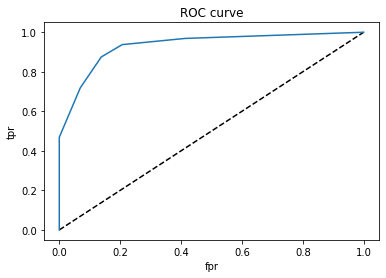

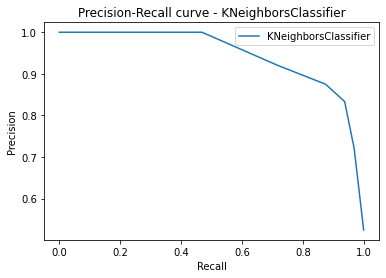

RandomForestClassifier CV Scores: [0.83333333 0.83018868 0.77358491 0.90566038 0.81132075]
RandomForestClassifier Accuracy: 0.8360655737704918
RandomForestClassifier Confusion Matrix: [[26  3]
 [ 7 25]]
RandomForestClassifier ROC AUC: 0.9240301724137931
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        29
           1       0.89      0.78      0.83        32

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



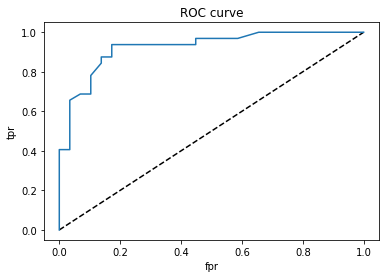

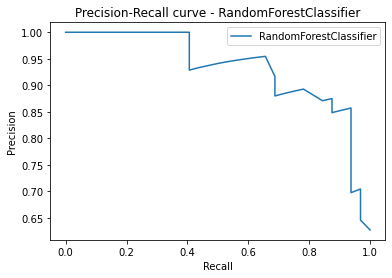

GradientBoostingClassifier CV Scores: [0.87037037 0.86792453 0.79245283 0.86792453 0.75471698]
GradientBoostingClassifier Accuracy: 0.8852459016393442
GradientBoostingClassifier Confusion Matrix: [[27  2]
 [ 5 27]]
GradientBoostingClassifier ROC AUC: 0.915948275862069
              precision    recall  f1-score   support

           0       0.84      0.93      0.89        29
           1       0.93      0.84      0.89        32

    accuracy                           0.89        61
   macro avg       0.89      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



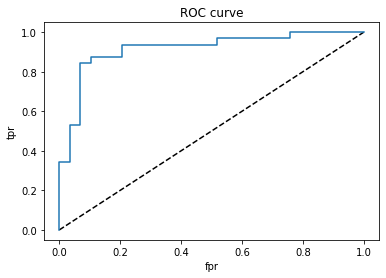

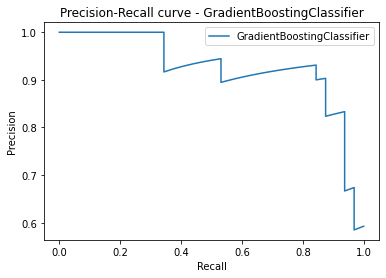

XGBClassifier CV Scores: [0.87037037 0.88679245 0.71698113 0.90566038 0.81132075]
XGBClassifier Accuracy: 0.8852459016393442
XGBClassifier Confusion Matrix: [[26  3]
 [ 4 28]]
XGBClassifier ROC AUC: 0.9213362068965518
              precision    recall  f1-score   support

           0       0.87      0.90      0.88        29
           1       0.90      0.88      0.89        32

    accuracy                           0.89        61
   macro avg       0.88      0.89      0.89        61
weighted avg       0.89      0.89      0.89        61



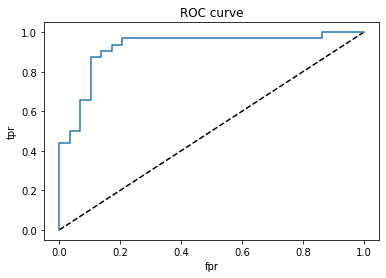

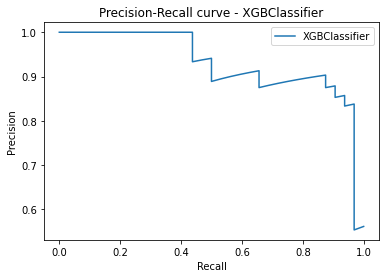

In [8]:
# Improved model evaluation and cross-validation
model_results = []

# Looping through models and evaluating their performance
for name, model in classifiers.items():
    try:
        logger.info(f"Training and evaluating {name} model.")
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_resampled, y_resampled.values.ravel(), cv=5, scoring='accuracy')

        # Model training
        model.fit(X_resampled, y_resampled)
        predict = model.predict(X_test)
        acc = accuracy_score(y_test, predict)
        conf = confusion_matrix(y_test, predict)

        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        precision = precision_score(y_test, predict)
        recall = recall_score(y_test, predict)
        f1 = f1_score(y_test, predict)

        # Precision-Recall curve
        precision_recall_thresholds = precision_recall_curve(y_test, y_pred_proba)

        model_results.append({'Model': name, 'Accuracy': acc, 'ROC AUC': roc_auc, 'Precision': precision, 'Recall': recall, 'F1 Score': f1, 'CV Scores': cv_scores})
        
        print("=============================================================================")
        print(name, "CV Scores:", cv_scores)
        print(name, "Accuracy:", acc)
        print(name, "Confusion Matrix:", conf)
        print(name, "ROC AUC:", roc_auc)
        print(classification_report(y_test, predict))
        
        logger.info(f"{name} - CV Scores: {cv_scores}")
        logger.info(f"{name} - Accuracy: {acc}")
        logger.info(f"{name} - Confusion Matrix:\n{conf}")
        logger.info(f"{name} - ROC AUC: {roc_auc}")
        logger.info(f"{name} - Precision: {precision}")
        logger.info(f"{name} - Recall: {recall}")
        logger.info(f"{name} - F1 Score: {f1}")
        logger.info(classification_report(y_test, predict))

        # Plotting the ROC curve
        plt.plot([0, 1], [0, 1], 'k--')
        plt.plot(fpr, tpr, label='Knn')
        plt.xlabel('fpr')
        plt.ylabel('tpr')
        plt.title('ROC curve')
        plt.show()
        
        # Plotting the Precision-Recall curve
        plt.plot(precision_recall_thresholds[1], precision_recall_thresholds[0], label=name)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall curve - {name}')
        plt.legend()
        plt.show()
    
    except Exception as ex:
        logger.error(f"An error occurred while processing {name} model: {ex}")

In [9]:
df_results = pd.DataFrame(model_results)
df_results[['Model','Accuracy','ROC AUC','Precision','Recall','F1 Score']]

,Model,Accuracy,ROC AUC,Precision,Recall,F1 Score
0,AdaBoostClassifier,0.786885,0.838362,0.851852,0.718750,0.779661
1,LogisticRegression,0.901639,0.937500,0.933333,0.875000,0.903226
2,KNeighborsClassifier,0.868852,0.932651,0.875000,0.875000,0.875000
3,RandomForestClassifier,0.836066,0.924030,0.892857,0.781250,0.833333
4,GradientBoostingClassifier,0.885246,0.915948,0.931034,0.843750,0.885246
5,XGBClassifier,0.885246,0.921336,0.903226,0.875000,0.888889


In [10]:
# Feature importance for tree-based models
for name, model in classifiers.items():
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier)):
        model.fit(X_train, y_train)
        feature_importances = model.feature_importances_
        feature_names = X_train.columns
        importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
        print(f"{name} - Feature Importance:")
        print(importance_df.sort_values(by='Importance', ascending=False))

RandomForestClassifier - Feature Importance:
      Feature  Importance
4     oldpeak    0.120166
3    thalachh    0.114876
20    thall_2    0.108515
0         age    0.088052
2        chol    0.085814
1      trtbps    0.074509
21    thall_3    0.061292
6      exng_1    0.060458
7       caa_1    0.043897
5       sex_1    0.035226
18      slp_2    0.034886
12       cp_2    0.034695
17      slp_1    0.027435
8       caa_2    0.022820
15  restecg_1    0.019718
9       caa_3    0.016738
13       cp_3    0.013440
11       cp_1    0.013412
14      fbs_1    0.011630
19    thall_1    0.008561
10      caa_4    0.002553
16  restecg_2    0.001307
GradientBoostingClassifier - Feature Importance:
      Feature  Importance
4     oldpeak    0.136611
20    thall_2    0.121856
6      exng_1    0.095411
21    thall_3    0.089001
7       caa_1    0.084428
18      slp_2    0.084205
3    thalachh    0.054794
8       caa_2    0.052714
0         age    0.048678
12       cp_2    0.045781
2        chol    0.041

In [11]:
# Save trained models for deployment
for name, model in classifiers.items():
    joblib.dump(model, f"{name}_model.joblib")

# Hyperparameter Tuning RandomForest

In [12]:
# instantiating the object
model = RandomForestClassifier()

# setting a grid - not so extensive
parameters = {'n_estimators': [50, 60],
    'max_depth': [2,3,10,15,20,25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]}

# instantiating the GridSearchCV object
# For binary classification:
# 'accuracy': Calculates the accuracy of the classifier.
# 'precision': Measures the ability of the classifier not to label as positive a sample that is negative.
# 'recall': Measures the ability of the classifier to capture all the positive samples.
# 'f1': Combines precision and recall into a single metric.
# 'roc_auc': Computes the area under the Receiver Operating Characteristic (ROC) curve.

searcher = GridSearchCV(estimator = model, param_grid = parameters,cv=5, scoring='accuracy')

# fitting the object
searcher.fit(X_train, y_train)

# the scores
print("The best params are :", searcher.best_params_)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# printing the test accuracy
print("The test accuracy score of model after hyper-parameter tuning is ", accuracy_score(y_test, y_pred))

The best params are : {'max_depth': 25, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
The best score is   : 0.822278911564626
The test accuracy score of model after hyper-parameter tuning is  0.8852459016393442


# Hyperparameter Tuning LOGREG

In [13]:
# instantiating the object
model = LogisticRegression()

# Define a parameter grid
parameters = {
    'C': np.logspace(-3, 3,4, 5,7),  # Regularization parameter
    'penalty': ['None','l1', 'l2','elasticnet'],       # Regularization type
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],        # Solver algorithm
    'max_iter' :[50,100,200,300],
    'n_jobs' :[-1]
}

# instantiating the GridSearchCV object
# For binary classification:
# 'accuracy': Calculates the accuracy of the classifier.
# 'precision': Measures the ability of the classifier not to label as positive a sample that is negative.
# 'recall': Measures the ability of the classifier to capture all the positive samples.
# 'f1': Combines precision and recall into a single metric.
# 'roc_auc': Computes the area under the Receiver Operating Characteristic (ROC) curve.

searcher = GridSearchCV(estimator = model, param_grid = parameters,cv=5, scoring='accuracy')

# fitting the object
searcher.fit(X_train, y_train)

# Get the best hyperparameters from the GridSearchCV
best_params = searcher.best_params_

# the scores
print("The best params are :", best_params)
print("The best score is   :", searcher.best_score_)

# predicting the values
y_pred = searcher.predict(X_test)

# printing the test accuracy
print("The test accuracy score of model after hyper-parameter tuning is ", accuracy_score(y_test, y_pred))

The best params are : {'C': 343.0, 'max_iter': 50, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}
The best score is   : 0.8428571428571429
The test accuracy score of model after hyper-parameter tuning is  0.8688524590163934


# TURNING LOGREG MODEL INTO SQL IMPLEMENTATION

In [14]:
print(best_params)
model=LogisticRegression(**best_params)
model.fit(X_train,y_train)
predict = model.predict(X_test)
acc = accuracy_score(y_test, predict)
conf = confusion_matrix(y_test, predict)

y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test,y_pred_proba)

print(name,acc)
print(conf)    
print(roc_auc)
print(classification_report(y_test,predict))

{'C': 343.0, 'max_iter': 50, 'n_jobs': -1, 'penalty': 'l1', 'solver': 'liblinear'}
XGBClassifier 0.8688524590163934
[[25  4]
 [ 4 28]]
0.9191810344827587
              precision    recall  f1-score   support

           0       0.86      0.86      0.86        29
           1       0.88      0.88      0.88        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



# MANUAL PROB CALCULATION

- Prob = 

```1 / (1 + EXP(-(
            -- Intercept
                <intercept> +
            -- Coefficients for each feature
                <coef_1> * (feature_1 - <median_1>) / <iqr_1> +
                <coef_2> * (feature_2 - <median_2>) / <iqr_2> +
                -- ... Repeat for all features ...
    <coef_n> * (feature_n - <median_n>) / <iqr_n>```

In [15]:
# Get the model coefficients
coefficients = model.coef_[0]

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to display the coefficients along with the feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

intercept = model.intercept_[0]
print('Intercept =',intercept)

# Print the DataFrame
print(coefficients_df)
coefficients_list = coefficients_df.values.tolist()

# Get centering and scaling values for each feature
print("Centering",centering)
print("iqrs",iqrs)

Intercept = 1.489433330981952
      Feature  Coefficient
0         age     0.376840
1      trtbps    -0.538095
2        chol    -0.169705
3    thalachh     0.534134
4     oldpeak    -0.843658
5       sex_1    -2.010056
6      exng_1    -1.036147
7       caa_1    -2.798959
8       caa_2    -3.986276
9       caa_3    -2.267926
10      caa_4     6.315829
11       cp_1     0.656592
12       cp_2     2.060585
13       cp_3     2.892969
14      fbs_1     0.625521
15  restecg_1     0.476695
16  restecg_2    -0.345796
17      slp_1    -0.230493
18      slp_2     1.627226
19    thall_1     0.679748
20    thall_2     0.285275
21    thall_3    -1.178254
Centering [ 55.  130.  240.  153.    0.8]
iqrs [13.5 20.  63.5 32.5  1.6]


In [16]:
df1_Scored = df1
df1_Scored['prob_Manual'] =             1/(1+np.exp(-(intercept +  \
                                        coefficients_list[0][1] * (df1_Scored[coefficients_list[0][0]] - centering[0] ) / iqrs[0] + \
                                        coefficients_list[1][1] * (df1_Scored[coefficients_list[1][0]] - centering[1] ) / iqrs[1] + \
                                        coefficients_list[2][1] * (df1_Scored[coefficients_list[2][0]] - centering[2] ) / iqrs[2] + \
                                        coefficients_list[3][1] * (df1_Scored[coefficients_list[3][0]] - centering[3] ) / iqrs[3] + \
                                        coefficients_list[4][1] * (df1_Scored[coefficients_list[4][0]] - centering[4] ) / iqrs[4] + \
                                        coefficients_list[5][1] * (df1_Scored[coefficients_list[5][0]]) +  \
                                        coefficients_list[6][1] * (df1_Scored[coefficients_list[6][0]]) +  \
                                        coefficients_list[7][1] * (df1_Scored[coefficients_list[7][0]]) +  \
                                        coefficients_list[8][1] * (df1_Scored[coefficients_list[8][0]]) +  \
                                        coefficients_list[9][1] * (df1_Scored[coefficients_list[9][0]]) +  \
                                        coefficients_list[10][1] * (df1_Scored[coefficients_list[10][0]]) +  \
                                        coefficients_list[11][1] * (df1_Scored[coefficients_list[11][0]]) +  \
                                        coefficients_list[12][1] * (df1_Scored[coefficients_list[12][0]]) +  \
                                        coefficients_list[13][1] * (df1_Scored[coefficients_list[13][0]]) +  \
                                        coefficients_list[14][1] * (df1_Scored[coefficients_list[14][0]]) +  \
                                        coefficients_list[15][1] * (df1_Scored[coefficients_list[15][0]]) +  \
                                        coefficients_list[16][1] * (df1_Scored[coefficients_list[16][0]]) +  \
                                        coefficients_list[17][1] * (df1_Scored[coefficients_list[17][0]]) +  \
                                        coefficients_list[18][1] * (df1_Scored[coefficients_list[18][0]]) +  \
                                        coefficients_list[19][1] * (df1_Scored[coefficients_list[19][0]]) +  \
                                        coefficients_list[19][1] * (df1_Scored[coefficients_list[20][0]]) +  \
                                        coefficients_list[19][1] * (df1_Scored[coefficients_list[21][0]]) +  \
                                                      0 )))
                                                                                              

In [17]:
roc_auc = roc_auc_score(df1_Scored['output'],df1_Scored['prob_Manual'])
print(roc_auc)
df1_Scored[df1_Scored['output'] == 0].head(10)

0.9263943785682917


,age,trtbps,chol,thalachh,oldpeak,output,sex_1,exng_1,caa_1,caa_2,caa_3,caa_4,cp_1,cp_2,cp_3,fbs_1,restecg_1,restecg_2,slp_1,slp_2,thall_1,thall_2,thall_3,prob_Manual
165,67,160,286,108,1.500000,0,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0.006186
166,67,120,229,129,2.600000,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.003007
167,62,140,268,160,3.600000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0.034659
168,63,130,254,147,1.400000,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.043132
169,53,140,203,155,3.100000,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0.160114
170,56,130,256,142,0.600000,0,1,1,1,0,0,0,0,1,0,1,0,0,1,0,1,0,0,0.212396
171,48,110,229,168,1.000000,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0.858826
172,58,120,284,160,1.800000,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0.600652
173,58,132,224,173,3.200000,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0.268266
174,60,130,206,132,2.400000,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0.002347


# SQL IMPLEMENTATION

```
SELECT
  1 / (1 + EXP(-(
    -- Intercept
    <intercept> +
    -- Coefficients for each feature
    <coef_1> * (feature_1 - <median_1>) / <iqr_1> +
    <coef_2> * (feature_2 - <median_2>) / <iqr_2> +
    -- ... Repeat for all features ...
    <coef_n> * (feature_n - <median_n>) / <iqr_n>
  ))) AS predicted_probability
FROM your_table_with_unscaled_features;
```


In [18]:
sql_table_name = ''
column_name = ''

# END

In [19]:
# Save log messages to a file
# File handling: close the FileHandler
file_handler.close()
logger.removeHandler(file_handler)